In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
# signal = ObjIter([])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])
# signal20 = ObjIter([ Tree(f, report=False, altfile="yy_quadh_bkg10_soft025_md_allsig20_{base}") for f in tqdm(module.full_signal_list) ])
signal = ObjIter([ Tree(f, report=False, altfile="yy_quadh_bkg10_soft025_md_allsig_{base}") for f in tqdm(module.full_signal_list) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


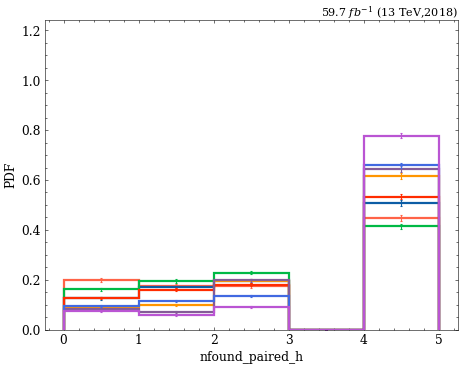

In [6]:
study.quick( 
    signal,
    masks=lambda t:t.nfound_select==8,
    varlist=['nfound_paired_h'],
    efficiency=True,
)

In [7]:
t = signal[0]

In [50]:
def reco_score(t):
    ids, y_ids = [], []
    for i, y in enumerate(['Y1','Y2']):
        h_ids = []
        for j, h in enumerate(['H1','H2']):
            b1_id, b2_id = [ (t[f'{h}{y}_{b}_signalId']+2)//2 for b in ['b1','b2'] ]
            h_ids.append(ak.where(b1_id == b2_id, b1_id, 0))
        ids += [ h_id>0 for h_id in h_ids ]
        h1_id, h2_id = [ (h_id+1)//2 for h_id in h_ids ]
        y_ids.append(ak.where(h1_id == h2_id, h1_id, 0))
    ids += [ y_id>0 for y_id in y_ids ]
    return sum(ids)

100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


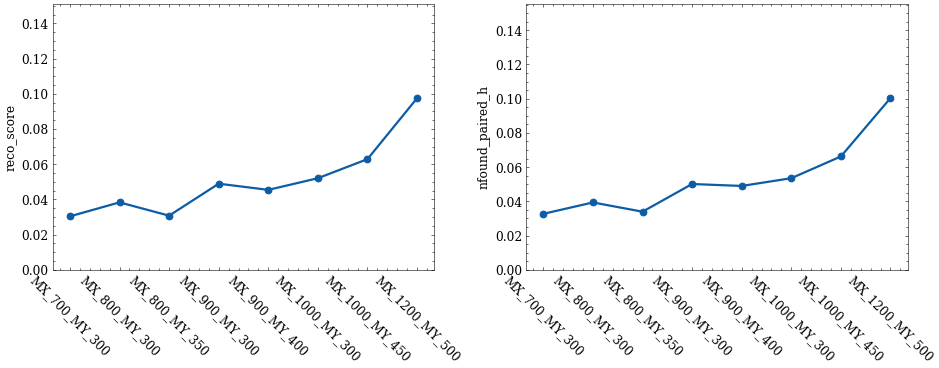

In [60]:
study.statsplot( 
    signal,
    # masks=lambda t:t.nfound_select==8,
    efficiency=True,
    varlist=[reco_score,'nfound_paired_h'],
    stat=lambda h:h.histo[-1]
)


100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


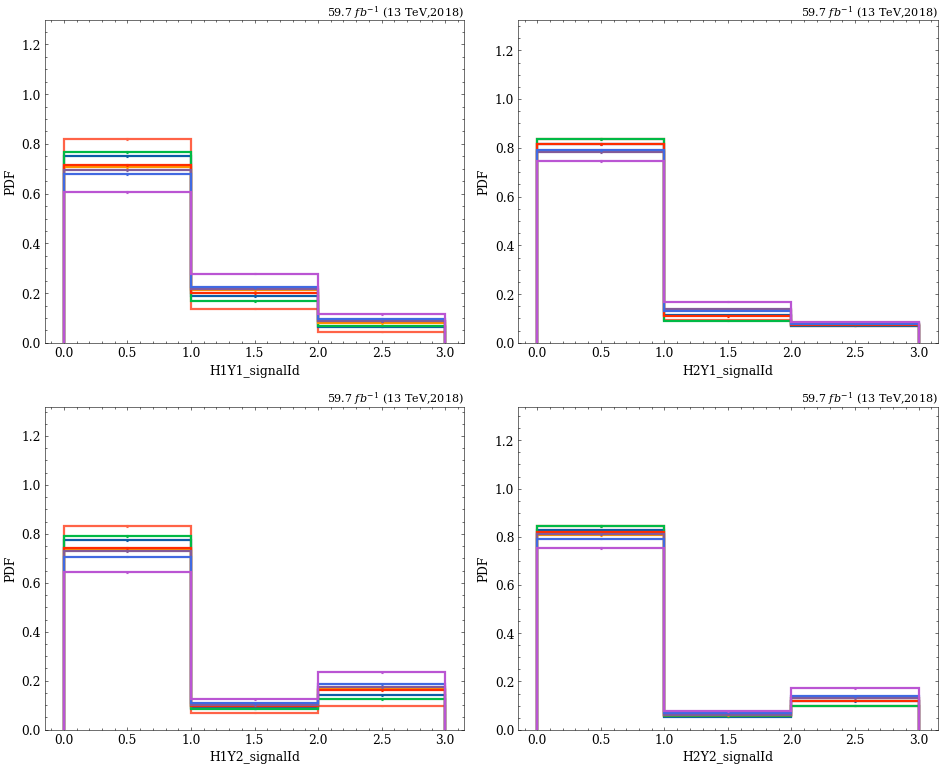

In [24]:
study.quick( 
    signal,
    # masks=lambda t:t.nfound_select==8,
    efficiency=True,
    transforms=lambda i:(i+2)//2,
    varlist=[f'{res}_signalId' for res in eightb.higgslist]
)


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


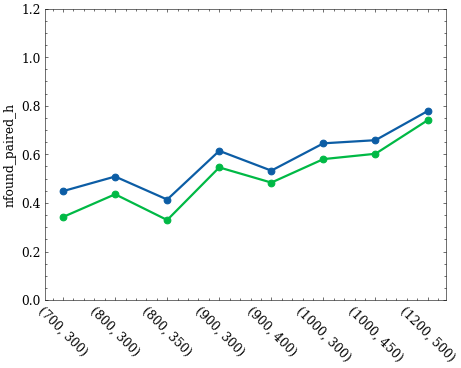

In [9]:
figax=study.get_figax()
study.statsplot( 
    signal,
    masks=lambda t:t.nfound_select==8,
    varlist=['nfound_paired_h'],
    label=signal.mass.list,
    efficiency=True,
    stat=lambda h:h.histo[-1],
    figax=figax,
    g_grid=True,g_ylim=(0,1.2),
)
study.statsplot( 
    signal20,
    masks=lambda t:t.nfound_select==8,
    varlist=['nfound_paired_h'],
    label=signal.mass.list,
    efficiency=True,
    stat=lambda h:h.histo[-1],
    figax=figax,
    g_grid=True,g_ylim=(0,1.2),
)

In [25]:
varinfo.X_m=dict(bins=(500,2000,30))
varinfo.Y1_m=dict(bins=(0,1000,30))
varinfo.Y2_m=dict(bins=(0,1000,30))

In [28]:
class scalar_m_res(ObjTransform):
    @property
    def xlabel(self): return f'{self.res}_m resolution'
    def __call__(self, t):
        scalar_m = t[f'{self.res}_m']
        gen_m = t[f'gen_{self.res}_m']
        return scalar_m/gen_m

100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


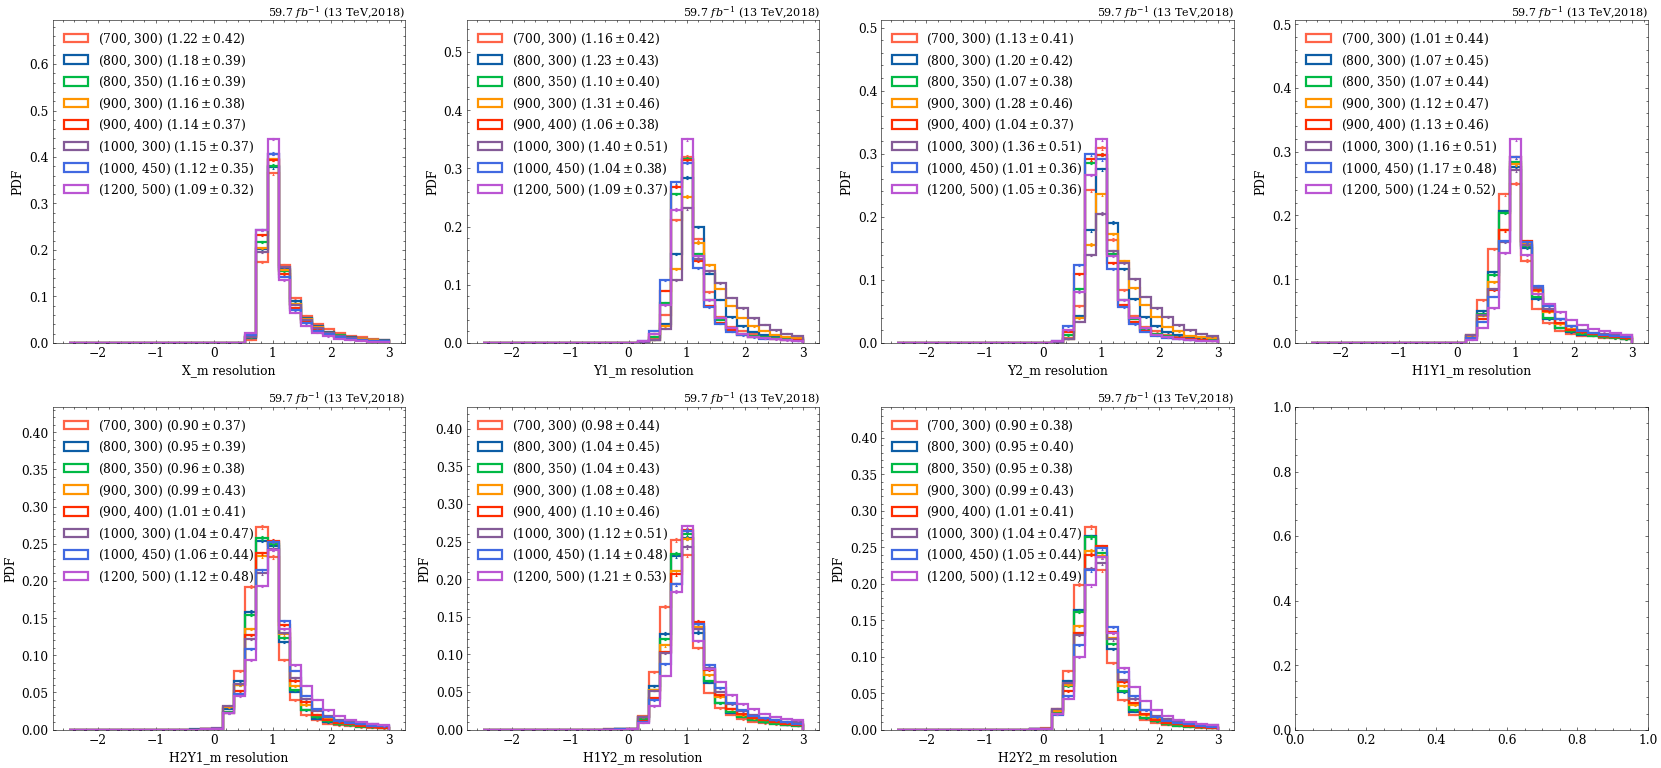

In [41]:
study.quick( 
    signal,
    legend=True, h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    # masks=lambda t:t.nfound_select==8,
    varlist=[scalar_m_res(res=res) for res in eightb.scalarlist],
    binlist=[(-2.5,3,30)]*10,
    label=signal.mass.list,
    efficiency=True,
)

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


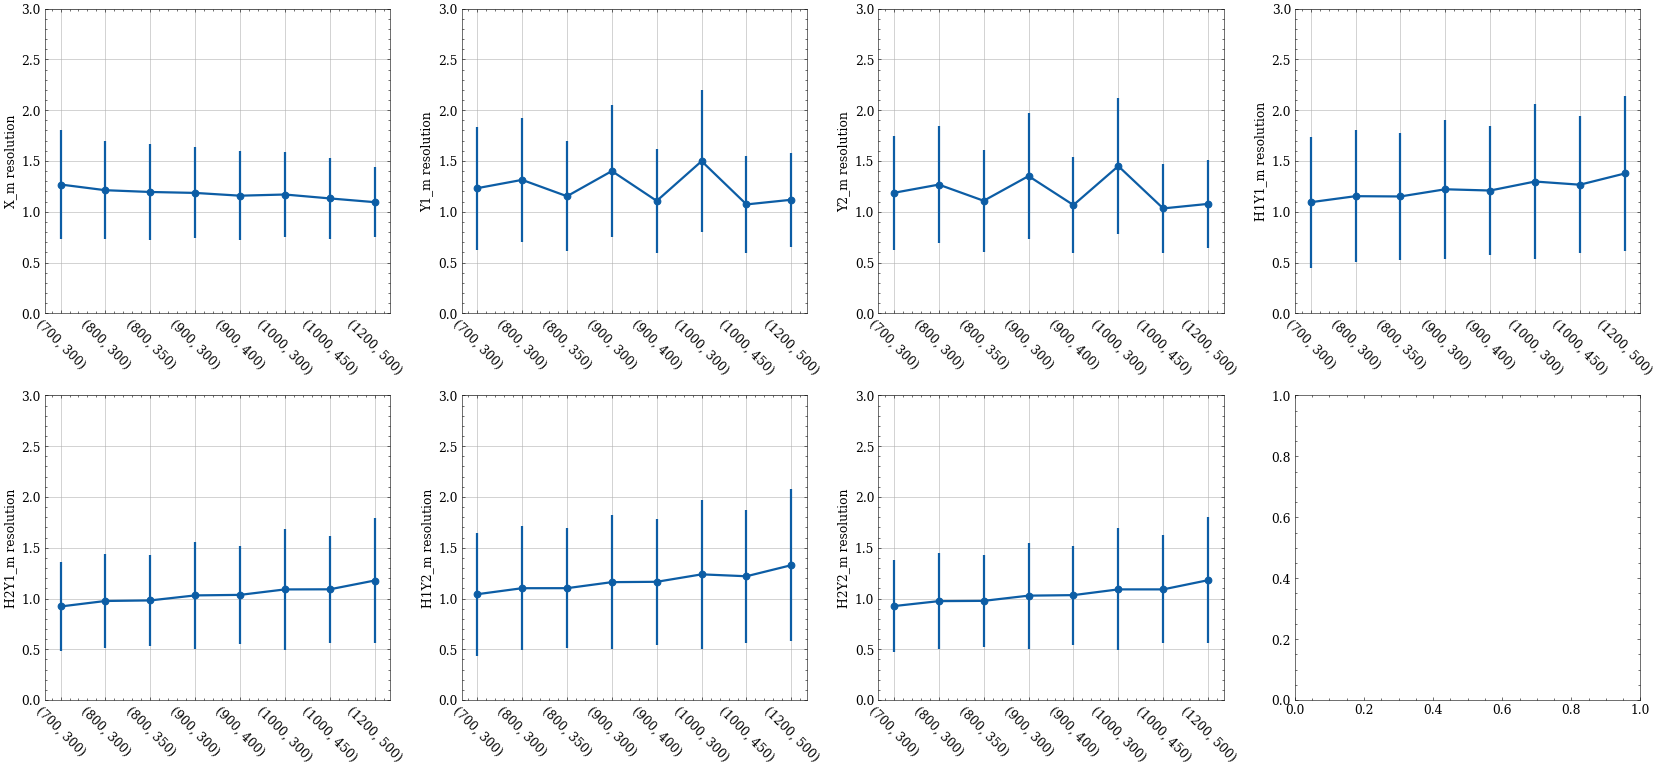

In [44]:
study.statsplot( 
    signal,
    legend=True, 
    # masks=lambda t:t.nfound_select==8,
    varlist=[scalar_m_res(res=res) for res in eightb.scalarlist],
    binlist=[(0,5,30)]*10,
    label=signal.mass.list,
    efficiency=True,

    stat='{stats.mean}',
    stat_err='{stats.stdv}',
    g_grid=True, g_ylim=(0,3)
)